El siguiente ejercicio se siguió con el [video de OpenCV University](https://www.youtube.com/watch?v=cispWZOBeps)

## Importando bibliotecas

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time
%matplotlib inline



In [4]:
def set_seeds():
    '''
    Sets a fixed seed value for reproducibility acrros multiple libraries
    This ensures that mdel training and results remain consistent across
    multitple runs.
    '''
    seed_value = 42
    # set seed for pythons built-in random module
    random.seed(seed_value)

    # Setting seed for NumPy
    np.random.seed(seed_value)

    # Setting seed for PyTorch
    torch.manual_seed(seed_value)

    # If CUDA (GPU Support) is available, set additional seeds to control randomnes in GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

        # Ensure deterministic behavior of cuDNN operations
        torch.backends.cudnn.deterministic = True
        # Enabling cuDNN benchmarking mode
        torch.backends.cudnn.benchmark = False

    # Calling the function
    set_seeds()

### 1. Preparing the DataLoader

The Fashion MNIST dataset can be downloaded with
```
torchvision.datasets
```
and contains 70,000 images partitioned into 60,000 for training and 10,000 for test.


In [5]:
# Step 1: Download the training set without normalization
# Image to Tensor
raw_transform = transforms.Compose([transforms.ToTensor()])

# Loading the Fashion MNIST dataset
train_set_raw = datasets.FashionMNIST(root='F_MNIST_data',download=True,train=True,
                                      transform=raw_transform
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.02MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.5MB/s]


In [7]:
# Step 2: Compute mean and std from the training set
all_pixels = torch.cat([img.view(-1) for img,_ in train_set_raw])
mean = all_pixels.mean().item()
std = all_pixels.std().item()
print(f'Computed mean: {mean:.4f}, Computed std: {std:.4f}')

Computed mean: 0.2860, Computed std: 0.3530


In [8]:
# Step 3: Define the new transform using the computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))
])

ToTensor() seets the value between 0 and 1.

Normalize sets the values with a mean of 0 and a std of 1.

$$ x_{norm} = \frac{x - mean}{std}$$

Therefore, the values are in the range of:

$$ (0-0.286)/0.353 = -0.81 $$
$$ (1-0.286)/0.353 = 2.02 $$

With 0 being black, and 1 being white.




In [10]:
# Step 4: Reload datasets with proper normalization
train_set = datasets.FashionMNIST(root='F_MNIST_data',download=True,train=True,
                                      transform=transform)
val_set = datasets.FashionMNIST(root='F_MNIST_data',download=True,train=False,
                                      transform=transform)
print('Total train set:',len(train_set))
print('Total validation set:',len(val_set))

Total train set: 60000
Total validation set: 10000


In [11]:
# Defining data loader for training and validation datasets
train_loader = torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=64,shuffle=False)

The Fashion MNIST contains 10 classes as follows:

- 0: T-Shirt/Top
- 1: Trouser
- 2 : Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
9: Ankle boot





In [12]:
# class to idx mapping
class_mapping = {
    0 : 'T-Shirt/Top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle Boot'
}

## 2. Dataset Visualization

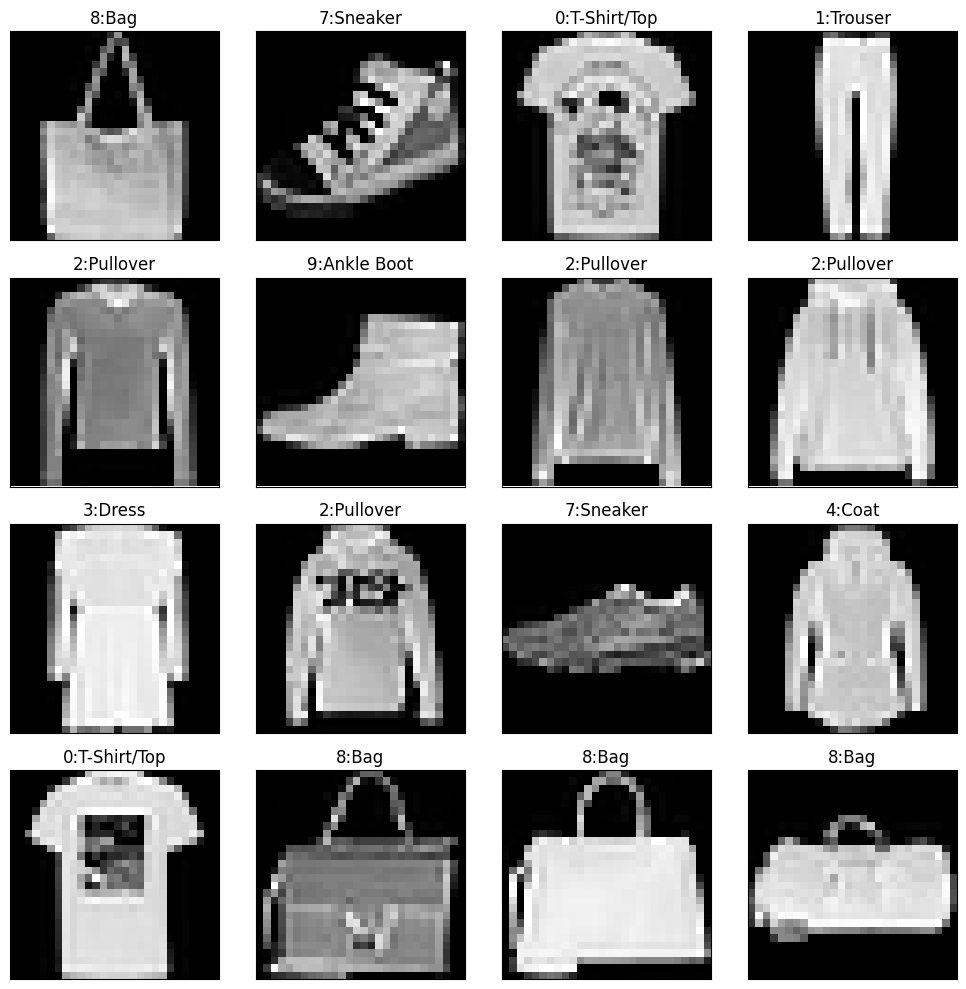

In [13]:
def visualize_images(trainloader,num_images=20):
    '''
    Function to visualize a batch of images from the training loader.

    Parameters:
    trainloader: DataLoader
    num_images: int, optional
    '''

    fig = plt.figure(figsize=(10,10))

    # Retrieve the first batch of images and labels from the trainloader
    images,labels = next(iter(trainloader))

    # Number of rows and calculate columns dynamically for subplots
    num_rows = 4
    num_cols = int(np.ceil(num_images/num_rows))

    # Loop through the umages up to the specified number
    for idx in range(min(num_images,len(images))):
        image,label = images[idx],labels[idx]

        # Subplot for each image
        ax = fig.add_subplot(num_rows,num_cols,idx+1,xticks=[],yticks=[])
        ax.imshow(np.squeeze(image),cmap='gray')

        # Title to show the label an class name
        ax.set_title(f'{label.item()}:{class_mapping[label.item()]}')

    plt.tight_layout()
    plt.show()

visualize_images(train_loader,num_images=16)

The size of the images is 28x28.
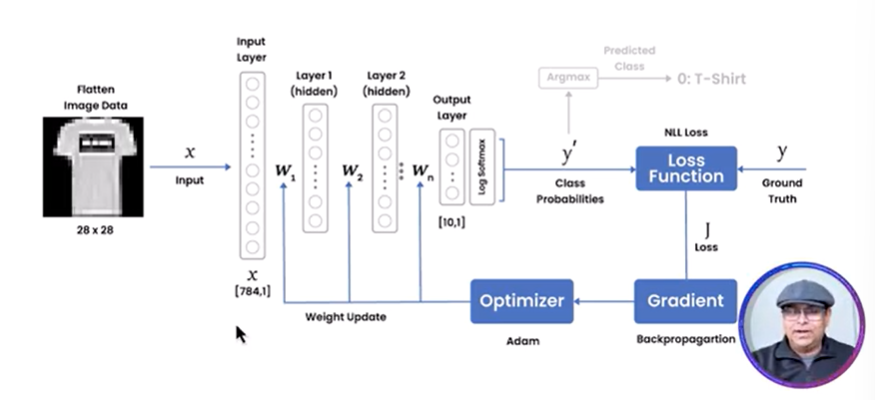


## Defining the architecture

In [19]:
class MLP(nn.Module):
    '''
    A Multi-Layer Perceptron modelo for classification tasks.
    This MLP consists of five fully connected layers with batch normalization,
    ReLU activations, and dropout for regularization
    '''
    def __init__(self,num_classes):
        '''
        Initializes the MLP model with the given number of output classes

        Parameters:
        num_classes: int (Number of output classes for classification)
        '''
        super().__init__()

        # Fully connected layers with decreasing number of neurons
        self.fc0 = nn.Linear(784,512) # Input layer: 784 (28x28 flatten) to 512 neurons
        self.bn0 = nn.BatchNorm1d(512) # Batch Normalization for stability

        self.fc1 = nn.Linear(512,256) # Hidden layer 1: 512 to 256 neurons
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256,128) # Hidden layer 2: 256 to 128 neurons
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128,64) # Hidden layer 3: 128 to 64 neurons
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, num_classes) # Output layer: 64 to num_classes neurons

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.3)

    def forward(self,x):
        '''
        Forward pass through the network.

        Parameters:
        x : torch.Tensor
            Input tensor of shape (batch_size,1,28,28)

        Returns:
        torch.Tensor
            Log-probabilities of each class after applying log_softmax
        '''

        # Flatten the input tensor from (batch_size,1,28,28) to (batch_size,784)
        x = x.view(x.shape[0],-1)

        # First fully connected layer: linear-batchnorm-relu-dropout
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)

        # Second fully connected layer: linear-batchnorm-relu
        x = F.relu(self.bn1(self.fc1(x)))

        # Third fully connected layer: linear-batchnorm-relu-dropout
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Fourth fully connected layer: linear-batchnorm-relu
        x = F.relu(self.bn3(self.fc3(x)))

        # Output layer: Linear - Log Softmax for classification
        x = F.log_softmax(self.fc4(x),dim=1) # Log probabilities for each class

        return x

In [20]:
# Instantiate the model with 10 output classes
mlp_model = MLP(num_classes=10)

Let's look at the parameters and the output shape after each layer

In [21]:
print(summary(mlp_model,input_size=(1,1,28,28),row_settings=['var_names']))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

## 4. Training

In [22]:
# Define the loss function
criterion = F.nll_loss # Negative log likelihood loss, commonly used for classification tasks

# Optimizer
optimizer = optim.Adam(mlp_model.parameters(),lr=1e-2)

# Epochs for training
num_epochs = 40

# Select the device for compution (GPU if available, otherwise CPU)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### 4.1 Model Training

In [24]:
def train(model,trainloader,criterion,optimizer,DEVICE):
    '''
    Trains the given model for one epoch using the provided training data.

    Parameters:
    models : nn.Module
    trainloader : Dataloader
    criterion: function
    optimizer : torch.optim.Optimizer
    DEVICE : str

    Returns:
    avg_loss : float
    accuracy : float
    '''
    # Set model to training mode
    model.train()

    # Move model to the specified device (GPU/CPU)
    model.to(DEVICE)

    # Initialze variables to track loss and accuracy
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Iterate over the training dataset
    for images,labels in trainloader:
        images,labels = images.to(DEVICE), labels.to(DEVICE)

        # Reset gradients to prevent acumulation from previous batches
        optimizer.zero_grad()

        # Forward pass: Get modelo predictions
        outputs = model(images)

        # COmpute the loss between predictions and ground truth labels
        loss = criterion(outputs,labels)

        # Backward pass: Compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Acumulate loss for averaging
        running_loss += loss.item()

        # Get predicted class with the highest probabilitu
        _, predicted = torch.max(outputs.data,dim=1)

        # Update total sample count
        total_samples += labels.size(0)

        # Update correct predictions count
        correct_predictions += (predicted == labels).sum().item()

    # Compute average loss across all batches
    avg_loss = running_loss / len(trainloader)

    # Compute accuracy as a percentage
    accuracy = 100 * correct_predictions / total_samples

    return avg_loss, accuracy



In [25]:
def validation(model,val_loader,criterion,DEVICE):
    '''
    Evaluates the given model on the validation dataset.

    Parameters:
    model: nn.Module

    val_loader: dataloader
    criterion: function
    DEVICE : str

    Returns:
    avg_loss: float
    accuracy: float
    '''

    # Set the model to evaluation model
    model.eval()

    # Move model to the specified device
    model.to(DEVICE)

    # Initialze variables to track loss and accuracu
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Disable gradient computation to save memory and speed up inference
    with torch.no_grad():
        # Iterate over the validation dataet
        for images,labels in val_loader:
            # Move images and labels to the specified device
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass: Get model predictions
            outputs = model(images)

            # Compute loss between predictions and ground truth labels
            loss = criterion(outputs,labels)

            # Accumulate loss for averaging
            running_loss += loss.item()

            # Get predicted class with the highest probability
            _, predicted = torch.max(outputs.data,dim=1)

            # Update total sample count
            total_samples += labels.size(0)

            # Count correctly predicted samples
            correct_predictions += (predicted == labels).sum().item()

    # Compute average loss across all batches
    avg_loss = running_loss / len(val_loader)

    # Compute accuracy as a percentage
    accuracy = 100 * correct_predictions / total_samples

    return avg_loss, accuracy



In [28]:
def main(model,trainloader,val_loader,epochs=5,DEVICE='cuda'):
    '''
    Trains and validates the given model over multiple epochs and plots the results.

    Parameters:
    model : nn.Module
    trainloader_ DataLoader
    val_loader_ DataLoader
    epochs : int,optimal
    DEVICE: str
    '''
    # Lists to store loss and accuracy values for plotting
    train_losses, val_losses = [],[]
    train_accuracies, val_accuracies = [],[]

    # Training loop for multiple epochs
    for epoch in range(epochs):
        # Train the model for one epochs:
        train_loss, train_accuracy = train(model,trainloader,criterion,optimizer,DEVICE)

        # Evaluate the model on the validation dataset
        val_loss, val_accuracy = validation(model,val_loader,criterion,DEVICE)

        # Store losses and accuracies for analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print training progress for each epochs
        print(f'Epoch {epoch+1:0>2}/{epochs}- Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%')

    # Plot training and validation loss
    plt.figure(figsize=(12,5))

    # Subplot 1: Loss over epochs
    plt.subplot(1,2,1)
    plt.plot(range(1,epochs+1),train_losses,label='Train Loss',marker='o')
    plt.plot(range(1,epochs+1),val_losses,label='Validation Loss',marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    # Subplot 2: Accuracy over epochs
    plt.subplot(1,2,2)
    plt.plot(range(1,epochs+1),train_accuracies,label='Train Accuracy',marker='o')
    plt.plot(range(1,epochs+1),val_accuracies,label='Validation Accuracy',marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


Epoch 01/40- Train Loss: 0.1560 - Train Accuracy: 94.36% - Val Loss: 0.3161 - Val Accuracy: 90.22%
Epoch 02/40- Train Loss: 0.1552 - Train Accuracy: 94.21% - Val Loss: 0.3035 - Val Accuracy: 90.08%
Epoch 03/40- Train Loss: 0.1528 - Train Accuracy: 94.31% - Val Loss: 0.3204 - Val Accuracy: 90.40%
Epoch 04/40- Train Loss: 0.1456 - Train Accuracy: 94.43% - Val Loss: 0.3314 - Val Accuracy: 90.01%
Epoch 05/40- Train Loss: 0.1491 - Train Accuracy: 94.39% - Val Loss: 0.3132 - Val Accuracy: 90.16%
Epoch 06/40- Train Loss: 0.1470 - Train Accuracy: 94.56% - Val Loss: 0.3104 - Val Accuracy: 89.99%
Epoch 07/40- Train Loss: 0.1430 - Train Accuracy: 94.66% - Val Loss: 0.3115 - Val Accuracy: 90.34%
Epoch 08/40- Train Loss: 0.1415 - Train Accuracy: 94.79% - Val Loss: 0.3185 - Val Accuracy: 90.28%
Epoch 09/40- Train Loss: 0.1392 - Train Accuracy: 94.77% - Val Loss: 0.3285 - Val Accuracy: 89.73%
Epoch 10/40- Train Loss: 0.1371 - Train Accuracy: 94.87% - Val Loss: 0.3227 - Val Accuracy: 90.28%
Epoch 11/4

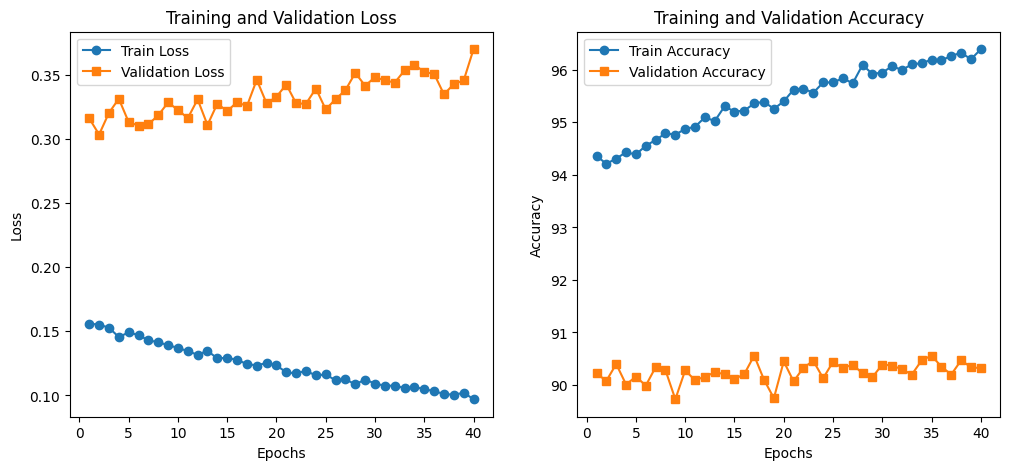

In [29]:
main(mlp_model,train_loader,val_loader,epochs=num_epochs,DEVICE=DEVICE)

## 5. Inference Results


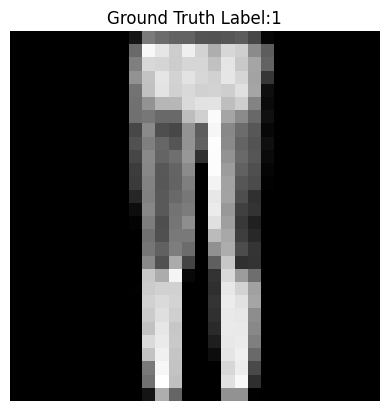

In [31]:
# Retrieve a batch of images and ground truth labels from the validation DataLoader
images,gt_labels = next(iter(val_loader))

# Randomly select and index from the batch
rand_idx = random.choice(range(len(images)))

# Display the randomly selected image
plt.imshow(images[rand_idx].squeeze(),cmap='gray') # Squeeze removes extra dimensions for grayscale images

# Title
plt.title('Ground Truth Label:' + str(int(gt_labels[rand_idx])),fontsize=12)

plt.axis('off')
plt.show()

In [38]:
from inspect import classify_class_attrs
# Set the model to evaluation mode
mlp_model.eval()

# Disabling gradient computation
with torch.no_grad():

    # Forward pass with the selected batch of images on the specified device
    batch_outputs = mlp_model(images.to(DEVICE))

# Compute softmax probabilities for each class in the batch
prob_score_batch = batch_outputs.softmax(dim=1).cpu() # Move to CPU for easier processing

# Probability distribution for the randomlu selected test image
prob_score_test_image = prob_score_batch[rand_idx]

# Get the predicted class ID
pred_cls_id =  prob_score_test_image.argmax()

print('Predictions for each class on the test image:\n')

# Iterate over all class probabilities and prin them
for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
        print(f'\033[1mClass: {idx} - {class_mapping[idx]},Probability: {cls_prob:.3f}\033[0m')
    else:
        print(f'Class: {idx} - {class_mapping[idx]},Probability: {cls_prob:.3f}')


Predictions for each class on the test image:

Class: 0 - T-Shirt/Top,Probability: 0.000
Class: 1 - Trouser,Probability: 1.000
Class: 2 - Pullover,Probability: 0.000
Class: 3 - Dress,Probability: 0.000
Class: 4 - Coat,Probability: 0.000
Class: 5 - Sandal,Probability: 0.000
Class: 6 - Shirt,Probability: 0.000
Class: 7 - Sneaker,Probability: 0.000
Class: 8 - Bag,Probability: 0.000
Class: 9 - Ankle Boot,Probability: 0.000
